# Analisis de Datos Faltantes sobre un Dataset de Boyas Oceanicas

In [1]:
# Librerias
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
#import session_info
import upsetplot

In [2]:
# linea para correr el notebook utils
%run utils.ipynb

## Cargar el conjunto de Datos desde una Web

In [3]:
# Guardar la url en una variable
datos_url = 'https://github.com/njtierney/naniar/raw/master/data/'

# Almacenar los nombres de los archivos a descargar en una lista
datasets_names = ('oceanbuoys', 'pedestrian', 'riskfactors')

# Almacenar el tipo de extension en una variable
extension = '.rda'

# diccionario que almacena los archivos descargados
datasets_dfs = {} 

for dataset_name in datasets_names:

    dataset_file = f'{ dataset_name }{ extension }' # almacena el nombre de cada archivo con su respectiva extension
    dataset_output_file = f'./data/{ dataset_file }' # ruta y nombre donde se guarda los archivos
    dataset_url = f'{ datos_url }{ dataset_file }' # url de cada archivo a descargar

    !wget -q -O { dataset_output_file } { dataset_url } # linea que descarga los archivos

    # almacenar en el diccionario los archivos descargados
    datasets_dfs[f'{ dataset_name }_df'] = pyreadr.read_r(dataset_output_file).get(dataset_name)

# accede a las llaves del diccionario para verificar que los archivos se hayan cargado
datasets_dfs.keys()

dict_keys(['oceanbuoys_df', 'pedestrian_df', 'riskfactors_df'])

### Incluir el conjunto de datos en nuestro ambiente local

In [4]:
locals().update(**datasets_dfs)
# elimina el diccionario para dejar solamente los dataframes
del datasets_dfs

In [5]:
# carga del dataframe
oceanbuoys_df.shape

(736, 8)

## Configuracion de las Graficas

In [23]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 8)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

## EDA de los datos

In [17]:
oceanbuoys_df

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
0,1997.0,0.0,-110.0,27.590000,27.150000,79.599998,-6.4,5.4
1,1997.0,0.0,-110.0,27.549999,27.020000,75.800003,-5.3,5.3
2,1997.0,0.0,-110.0,27.570000,27.000000,76.500000,-5.1,4.5
3,1997.0,0.0,-110.0,27.620001,26.930000,76.199997,-4.9,2.5
4,1997.0,0.0,-110.0,27.650000,26.840000,76.400002,-3.5,4.1
...,...,...,...,...,...,...,...,...
731,1993.0,-2.0,-110.0,24.780001,24.620001,90.800003,-4.4,1.7
732,1993.0,-2.0,-110.0,24.879999,24.500000,91.099998,-3.0,0.2
733,1993.0,-2.0,-110.0,25.120001,24.889999,89.699997,-4.0,1.1
734,1993.0,-2.0,-110.0,25.160000,24.930000,89.500000,-4.3,2.5


In [18]:
# Tipos de datos
oceanbuoys_df.dtypes

year          float64
latitude      float64
longitude     float64
sea_temp_c    float64
air_temp_c    float64
humidity      float64
wind_ew       float64
wind_ns       float64
dtype: object

Todas las variables son de tipo numerica flotante.

In [19]:
# variables que contienen valores nulos
(
    oceanbuoys_df
    .isna()
    .any()
)

year          False
latitude      False
longitude     False
sea_temp_c     True
air_temp_c     True
humidity       True
wind_ew       False
wind_ns       False
dtype: bool

Los valores nulos se concentran en las variables sea_temp_c, air_temp_c y humidity.

In [20]:
# Cantidad de valores nulos por variable
(
    oceanbuoys_df
    .isnull()
    .sum()
)

year           0
latitude       0
longitude      0
sea_temp_c     3
air_temp_c    81
humidity      93
wind_ew        0
wind_ns        0
dtype: int64

La mayor cantidad de valores nulos se concentran en air_temp_c y Humidity. Puede que haya alguna relacion entre estas variables.

In [21]:
# numero total de valores nulos
(
    oceanbuoys_df
    .isnull()
    .sum()
    .sum()
)

177

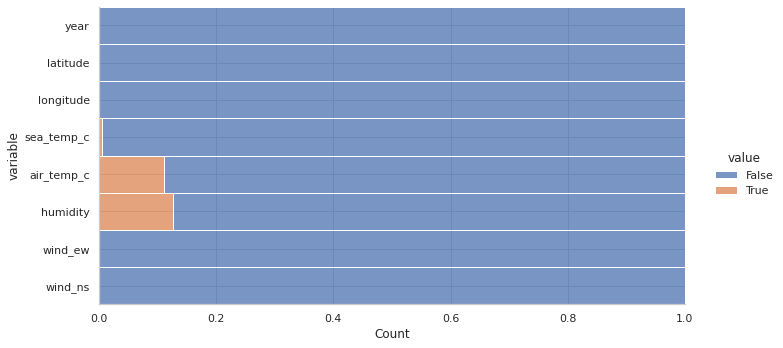

In [24]:
# Visualizacion de la proporcion de valores nulos por cada variable
(
    oceanbuoys_df
    .isnull()
    .melt()
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2
            )
        )
    )
)
plt.show()

In [26]:
# Numero de observaciones perdidas si se eliminan los valores faltantes
proof_oceanbuoys_df = (
    oceanbuoys_df
    .dropna()
)
proof_oceanbuoys_df.shape

(565, 8)

In [27]:
# numero de observaciones en el DF
oceanbuoys_df.shape

(736, 8)

In [28]:
# numero de observaciones eliminadas
736 - 565

171

In [30]:
# porcentaje que representa el numero de observaciones eliminadas
pct_of = 100 - (565/736)*100
pct_of

23.233695652173907

El dataframe contiene 736 observaciones. Si se eliminan los registros con valores faltantes quedan un total de 565 observaciones, es decir, se sacrifican mas de 171 observaciones que corresponden al 23% del total en el dataframe. Esto indica que no es recomendable utilizar el Metodo de eliminacion por lista para el tratamiento de valores faltantes ya que se pierde mucha informacion. 

## Analisis Basico de Valores Faltantes sobre el DF

### Calculo del Porcentaje de valores faltantes

In [8]:
# cantidad de datos
total = 736*8
total

5888

In [9]:
# cantidad de valores completos
v_complet = oceanbuoys_df.missing.number_complete()
v_complet

5711

In [11]:
# cantidad de valores faltantes
v_mising = oceanbuoys_df.missing.number_missing()
v_mising

177

In [16]:
# Porcentaje de valores faltantes en el DF
pct_v = (v_mising/v_complet)*100
pct_v

3.09928208720014

Alrededor del 3% de los datos corresponden a valores faltantes. Aunque no representa un numero amplio, vamos a aplicar todo el analisis requerido.